# Compare the words use between Twitter accounts (Yichang Su)

This task foucus on analyzing the words current and former President use on Twitter

Target at three main goals:
1. Generate dataframe(s) from the tweets data provided
2. Extract useful information like Tweet text, created_time, hashtags
3. Compare the word use between the accounts (realDonaldTrump, JoeBiden, KamalaHarris)

First, we'll insert some libraries and useful modules:

In [19]:
import pandas as pd
import numpy as np
import json
from datetime import datetime
import matplotlib.pyplot as plt
import re
import itertools
import collections
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# 1. Upload data and generate dataframes
Upload tweet files and store each person's data to three different dictionaries foucus only on three improtant information: tweet text, time tweet created, and hashtags

In [20]:
def convert_file(file, fname):
    tweet_dict = []
    for object in file:
        tweet = json.loads(object)

        if fname.find('old') != -1:
            tweet['time_created'] = tweet["created_at"]
        else:
            #covert from twitter date to Python datetime date
            raw_time = tweet["created_at"]
            new_datetime = datetime.strftime(datetime.strptime(raw_time, '%a %b %d %H:%M:%S +0000 %Y'), '%Y-%m-%d')
            tweet['time_created'] = new_datetime
        tweet["tweet_text"] = tweet['full_text'] 
        if not tweet["entities"]["hashtags"]:
            tweet["hashtags"] = "None"
        else:
            tweet["hashtags"] = tweet["entities"]["hashtags"][0]["text"]
        tweet_dict.append(tweet)
    return tweet_dict

Construct dataframes from dictionaries created above:

In [21]:
def creat_df (flist, name):
    d = {'time_created': [], 'tweet_text': [], 'hashtags': []}
    df_tweets = pd.DataFrame(data=d)
    for fname in flist:
        if name == 'biden':
            path = "JoeBiden/" + fname
        elif name == 'harris':
            path = "KamalaHarris/" + fname
        elif name == "trump":
            path = "realDonaldTrump/" + fname
        new_file = open(path, "r")
        dict = convert_file(new_file,fname)
        columns = ['time_created', 'tweet_text', 'hashtags']
        df = pd.DataFrame(dict, columns=columns)
        df_tweets = df_tweets.append([df])
    return df_tweets

In [22]:
biden_file_list = ['tweets.2020-10-29-101802', 'tweets.2020-11-01-052114', 'tweets.2020-11-02-015555', 'tweets.2020-11-02-081001',
                   'tweets.2020-11-03-001002', 'tweets.2020-11-04-001001', 'tweets.old.2020-08-12-000000']
harris_file_list = ['tweets.2020-10-29-101802', 'tweets.2020-11-01-052114', 'tweets.2020-11-02-015555', 'tweets.2020-11-02-134203',
                    'tweets.2020-11-03-001002', 'tweets.2020-11-04-001001', 'tweets.old.2019-12-18-000000']
trump_file_list = ['tweets.2020-10-29-101802', 'tweets.2020-11-01-052114', 'tweets.2020-11-02-015555', 'tweets.2020-11-02-081001',
                   'tweets.2020-11-02-134203', 'tweets.2020-11-03-001002', 'tweets.2020-11-04-001001', 'tweets.old.2020-08-18-000000']
biden_df = creat_df(biden_file_list, 'biden')
harris_df = creat_df(harris_file_list, 'harris')
trump_df = creat_df(trump_file_list, 'trump')

After calling the create dataframe function we'll be able to get the following dataframes. I only include the Trump's and Biden's tweet dataframes since the code used to create the dataframe for Harris are exactly the same. 
Here is the top five rows of the dataframe. As you can see these dataframes contain three key in columns: time_created, tweet_text, and hashtags.

In [58]:
biden_df.head()

,time_created,tweet_text,hashtags
0,2020-10-30,"This storm will pass, and a new day will come....",None
1,2020-10-30,"Now more than ever, we need a president who wi...",None
2,2020-10-29,This election is about so much more than polic...,None
3,2020-10-29,"Here’s the bottom line: When we vote, things g...",None
4,2020-10-29,You have my word: if I have the honor of servi...,None


In [59]:
trump_df.head()

,time_created,tweet_text,hashtags
0,2020-10-30,If Sleepy Joe Biden is actually elected Presid...,None
1,2020-10-30,Biden will destroy the United States Supreme C...,None
2,2020-10-30,#BidenCrimeFamiily,BidenCrimeFamiily
3,2020-10-30,MAKE AMERICA GREAT AGAIN. VOTE!!!,None
4,2020-10-30,Watch the Great Red Wave!,None


# 2. Find the most frequent used words
In the next section we are going to find the most frquent used words in our study objects' previous tweets. We will find the number of times each words appeared in the whole dataset and plot the top 30 most common words to a horizontal bar chart.

In [25]:
def remove_url(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

Words like "the", "a", "and" usually appear a lot in a text, they have the high prbobility to become as the most frequent words. However, those words don't add meaningful information to the text we are trying to analysis. It would be best if we can exclude them from our most common words.
Stopwords offered by nltk package will do the job for us.

In [26]:
stop_words = set(stopwords.words('english'))

In [36]:
def find_most_frequent_word(name):
    if name == "biden":
        df = biden_df
    elif name == "harris":
        df = harris_df
    elif name == "trump":
        df = trump_df
    df = df.dropna()

    tweet_list = df['tweet_text'].to_list()
    all_tweets = [remove_url(tweet) for tweet in tweet_list]
    words_in_tweets = [tweet.lower().split() for tweet in all_tweets]
    words_without_stopwords = []
    for all_words in words_in_tweets:
        new_word_list = [word for word in all_words if not word in stop_words]
        words_without_stopwords.append(new_word_list)

    all_words = list(itertools.chain(*words_without_stopwords))  
    return collections.Counter(all_words)   #use the built-in Python library collections to get the count of how many times each word appears in the sample
                                            #reference: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-frequencies-in-python/

Once we get the frequncies of each word we store them into dataframes which will help us to plot the graph.

In [43]:
trump_words = find_most_frequent_word('trump')
biden_words = find_most_frequent_word('biden')
harris_words = find_most_frequent_word('harris')

trump_words_df = pd.DataFrame(trump_words.most_common(30), columns=['words', 'count'])
biden_words_df = pd.DataFrame(biden_words.most_common(30), columns=['words', 'count'])
harris_words_df = pd.DataFrame(harris_words.most_common(30), columns=['words', 'count'])

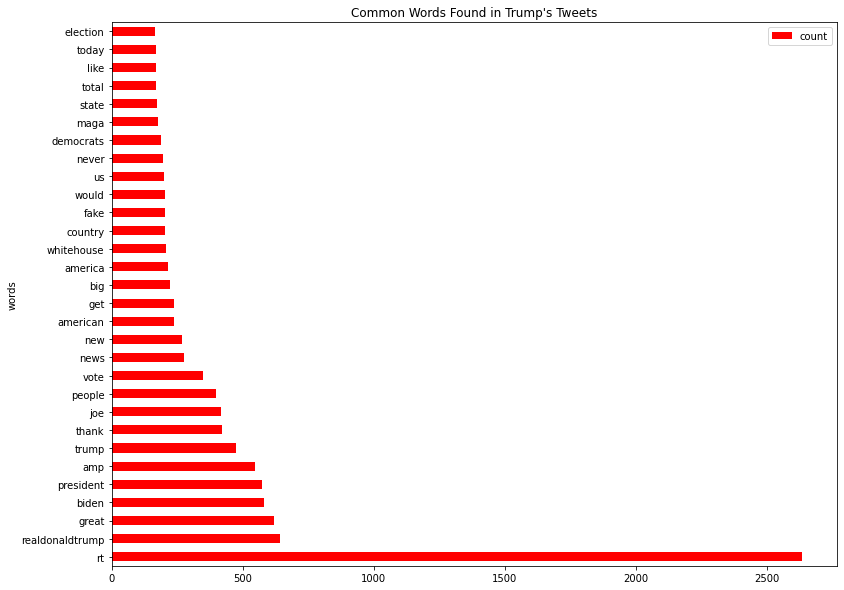

In [29]:
fig, ax = plt.subplots(figsize=(13, 10))
trump_words_df.plot.barh(x='words', y='count', ax=ax, color="Red")
ax.set_title("Common Words Found in Trump's Tweets")
plt.show()

Though, we exclude stopwords from our list, there are still a lot of meaningless words on our graph! What we can do to eliminate these words is to create an additional set which contains the words that appear a lot but don't have useful information. In the following step, we can union our customized set with the stopwords and run the code again to see if we can get a better outcome.

In [35]:
trivial_words = {'rt', 'you', 'would', 'us', 'never', 'total', 'must', 'day', 'need', 'make', 'time', 'act', 'one', 'get',
                     'every','take', 'cant', 'today', 'going', 'back', 'years', 'know', 'folks', 'im', 'plan', 'ensure',
                     'weve', 'want', 'complete', 'second', 'days', 'many', 'even', 'way'}
stop_words = stop_words.union(trivial_words)

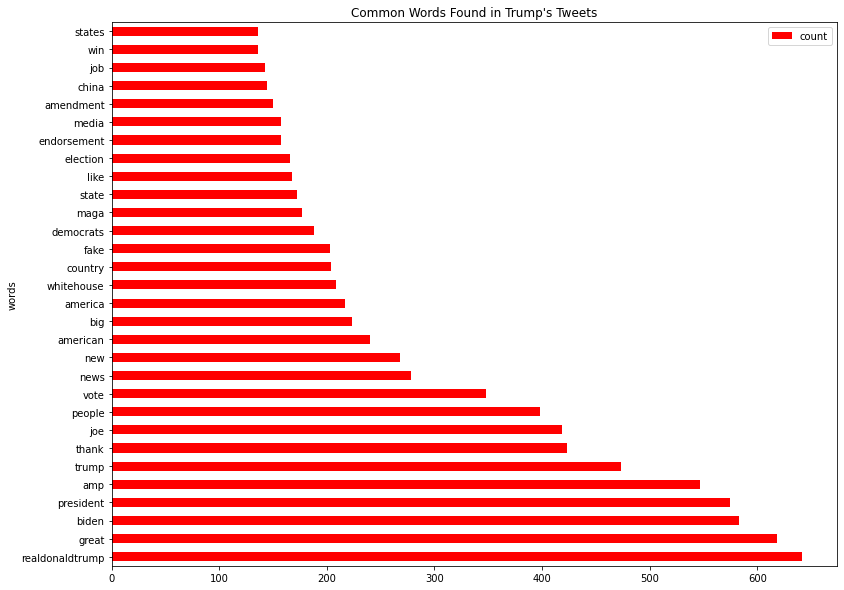

In [38]:
fig, ax = plt.subplots(figsize=(13, 10))
trump_words_df.plot.barh(x='words', y='count', ax=ax, color="Red")
ax.set_title("Common Words Found in Trump's Tweets")
plt.show()

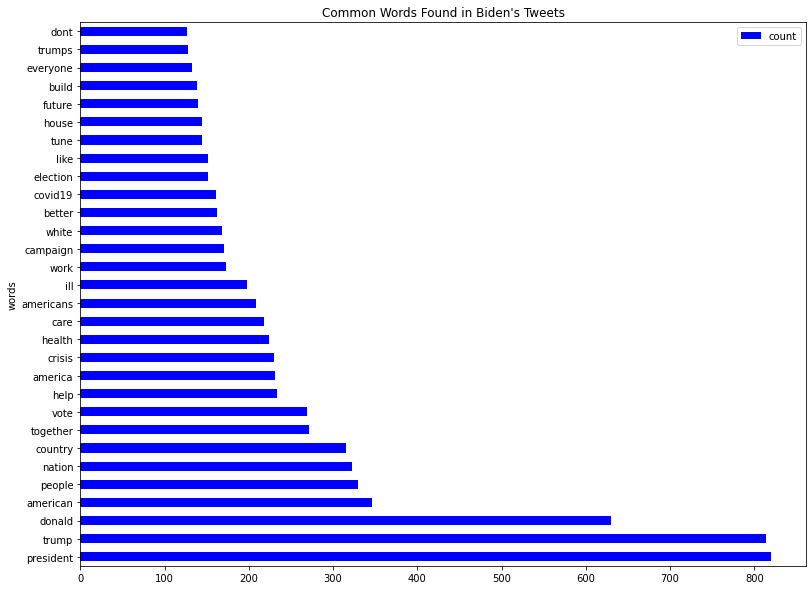

In [39]:
fig, ax = plt.subplots(figsize=(13, 10))
biden_words_df.plot.barh(x='words', y='count', ax=ax, color="Blue")
ax.set_title("Common Words Found in Biden's Tweets")
plt.show()

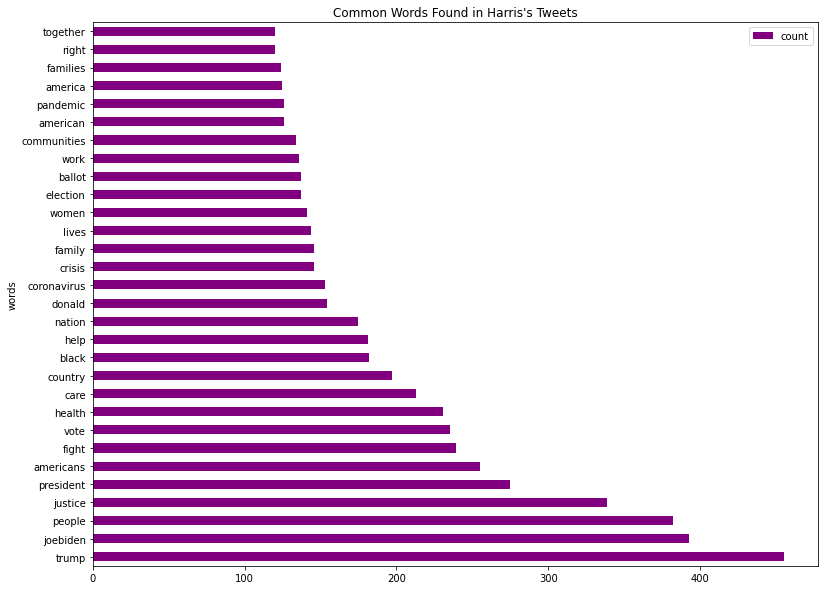

In [40]:
fig, ax = plt.subplots(figsize=(13, 10))
harris_words_df.plot.barh(x='words', y='count', ax=ax, color="Purple")
ax.set_title("Common Words Found in Harris's Tweets")
plt.show()

After implementing our customized set we do find that the graph only contains the meaningful words. 

# 3. Visualize the words
With the wordcloud package, we can even represent our text data in a colorful way which the size of each word indicates its frequency. This technique helps us to compare the word-use-difference between the three tweet accounts more directly and clearly. 

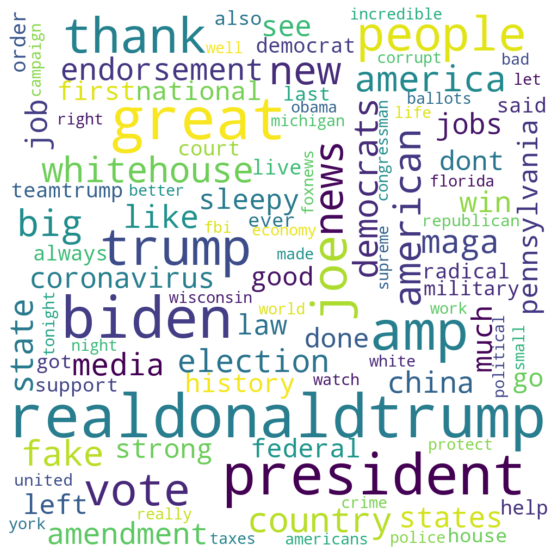

In [52]:
words_ordered_dict = {}
for word in trump_words.most_common(100):
    words_ordered_dict[word[0]] = word[1]
wordcloud = WordCloud(width=1000, height=1000, random_state=21, max_font_size=200, background_color = 'white').generate_from_frequencies(words_ordered_dict)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

plt.show()

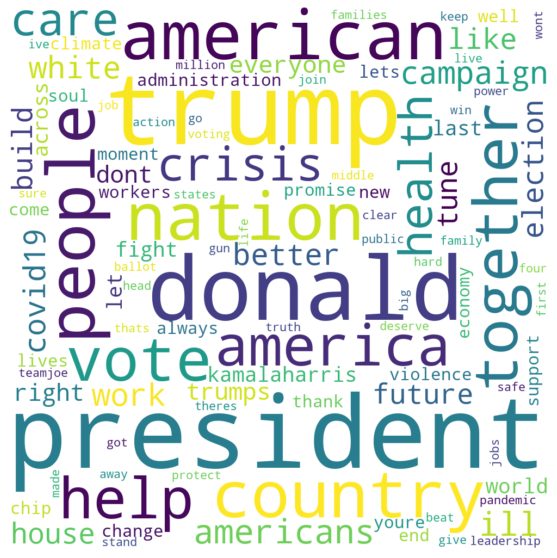

In [45]:
words_ordered_dict = {}
for word in biden_words.most_common(100):
    words_ordered_dict[word[0]] = word[1]
wordcloud = WordCloud(width=1000, height=1000, random_state=21, max_font_size=200, background_color = 'white').generate_from_frequencies(words_ordered_dict)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

plt.show()

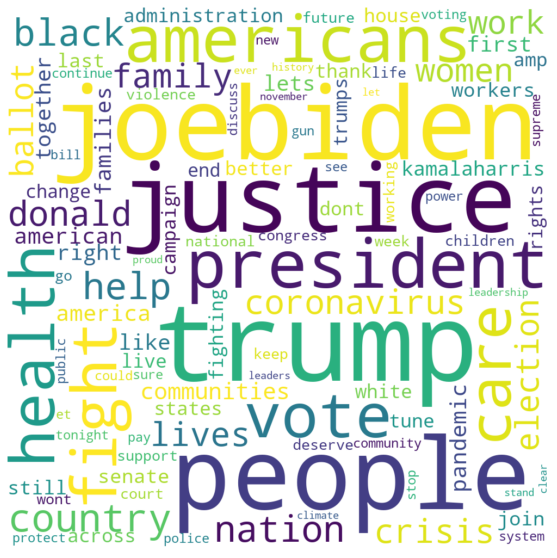

In [46]:
words_ordered_dict = {}
for word in harris_words.most_common(100):
    words_ordered_dict[word[0]] = word[1]
wordcloud = WordCloud(width=1000, height=1000, random_state=21, max_font_size=200, background_color = 'white').generate_from_frequencies(words_ordered_dict)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')

plt.show()

# 4. Summary
In this task we are able to find the words that are most frequently used in the tweets of previous and current presidents. From the graph above, we can clearly see that the most common words used by all three of them are presidents' names, words "president" and "vote". Considering the date our tweet data collected from (2020.10.29-2020.11.04), our task outcome matches with what we expect. President Trump and President Biden were busy on motivating people to vote on the election during these days. That's why they mentioned the word "vote" aggresively. 

Most profound rewarding from completing this task is that the data helps us understand the difference in President Trump and former Vice President Joe Biden's views of what America should be, and policies they are going to enact if they got elected. 

Trump's key words: China, news, fake, jobs

Biden's key words: health, covid19, work

Harris's key words: justice, health, coronavirus, black, women

With these keys words we are able to tell what issues they pay most attention to. For example, the word "China" appears a lot in President Trump's tweet, we can speculate that his aggressive focus on voters’ perceived fears about crime, China and immigration is to inherit their successful 2016 strategy which helped them regain ground lost support. Futhermore, compared with President Biden's frequent mention of Covid-19, President Trump rarely talked about this problem. He seemed to be trying to reduce the negative impact of this pandemic. 
Vice President Harris's key words are justice, black and women. As the first woman, first Black person and first Asian American to hold the office, Harris seemed to care more about the bias one could face as a colored individual and as a woman. She aims at bring justice to every American and diminishing racism and sexism. 



